<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/05_Advanced_RAG_Query_Expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): Query Expansion
This Notebook implements an advanced RAG system with Query Expansion technique to enhance document retrieval in RAG-based applications.

## Pre requisites

In [1]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 82 (delta 41), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (82/82), 10.94 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:
!pip install -r /content/RAG/rag_requirements.txt

## Imports

In [3]:
import os
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [4]:
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')

API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

llm_gpt4_turbo = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

## Use this if using open ai embeddings the Azure way
# EMBEDDING_API_KEY = os.getenv('API_KEY')
# EMBEDDING_API_BASE = os.getenv('API_BASE')
# EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

# embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
#                               openai_api_key=EMBEDDING_API_KEY,
#                               openai_api_base=EMBEDDING_API_BASE,
#                               openai_api_version=API_VERSION,
#                               openai_api_type=API_TYPE,
#                               chunk_size=1)

## Query Expansion

Query expansion refers to a set of techniques that rephrase the original query. Two popular methods that are easy to implement will be discussed in this notebook.

#### Technique 1 - Query expansion with a generated answer
Given an input query, this method first instructs an LLM to provide a hypothetical answer, whatever its correctness. Then, the query and the generated answer are combined in a prompt and sent to the retrieval system.


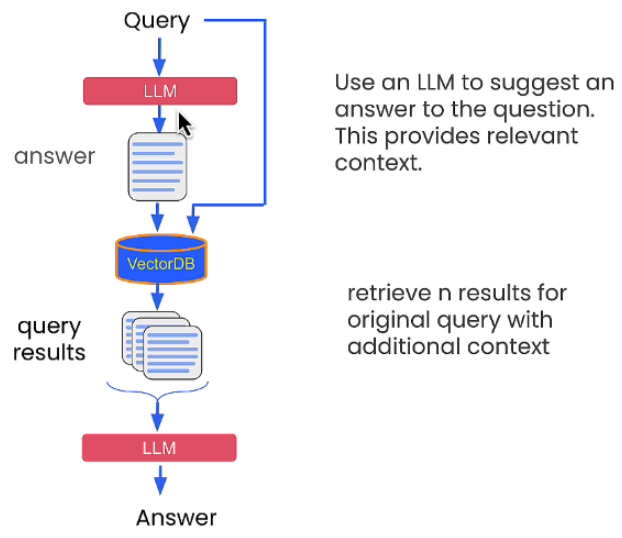

For a change we use an open source embedding model names Sentence Transformer (356 dimensionality)

In [ ]:
from RAG.utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
chroma_collection = load_chroma(filename='/content/RAG/data/Microsoft_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

Now let's make a function to generate a ficticious or hypothetical answer from an annual report for a given query

In [8]:
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser

def augment_query_generated(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report.
            Question: {question}""")
        | llm_gpt4_turbo | StrOutputParser()
    )
    return chain.invoke({'question':query})

Now we try to generate a hypothetical answer for a query and concatenate the two

In [9]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Example
Answer:

During the fiscal year 2022, we experienced a moderate level
of turnover within our executive team. We saw the departure of two key
executives: our Chief Financial Officer, Jane Doe, who retired after a
distinguished 10-year tenure with the company, and our Chief Technology
Officer, John Smith, who left to pursue an opportunity at another
firm.

To ensure a smooth transition and maintain our strategic
direction, we promptly filled these vacancies with highly qualified
individuals who bring a wealth of experience and fresh perspectives to
our executive team. Emily Johnson, a seasoned finance professional with
over 15 years of experience in the industry, joined us as the new CFO.
Meanwhile, Michael Brown, with a strong background in technology and
innovation, was appointed as the new CTO.

The rest of the executive
team remained stable, continuing to provide strong leadership and
support our long-term business objecti

Now we got a joint query which is a combination of thr original query and the hypothetical answer (generated by LLM)

Let' try to get top 5 documents from chroma collections which are close to the join query

In [10]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

# Print the retrieved documents
for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

part i item 1 20 information about our executive officers our executive
officers as of july 28, 202 2 were as follows : name age position with
the company satya nadella 54 chairman of the board and chief executive
officer judson althoff 49 executive vice president and chief commercial
officer christopher c. capossela 52 executive vice president, marketing
and consumer business, and chief marketing officer kathleen t. hogan 56
executive vice president, human resources amy e. hood 50 executive vice
president, chief financial officer bradford l. smith 63 president and
vice chair christopher d. young 50 executive vice president, business
development, strategy, and ventures mr. nadella was appointed chairman
of the board in june 2021 and chief executive officer in february 2014.
he

form of executive incentive plan performance stock award agreement
under the microsoft corporation 2001 stock plan 10 - q 9 / 30 / 16 10.
25 10 / 20 / 16 10. 22 * senior executive severance benefit plan 10 - q
9

In [11]:
import umap

# get the embeddings from the chroma collections
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

# Perform umap fit on the high dimensional embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 455/455 [05:28<00:00,  1.39it/s]


In [16]:
# Number of docs retrieved
len(results['embeddings'][0])

5

In [17]:
# Embedding vector length of each doc retrieved
len(results['embeddings'][0][0])

384

In [18]:
# get the embedding vectors for all the retrieved documents from the results obj.
retrieved_embeddings = results['embeddings'][0]

# Get the embedding for the original and the joint query
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

# Get the 2D umap fit of the original query
projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)

# Get the 2D umap fit of joint query
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)

# Get the 2D umap fit of the docs retrived using the joint query
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


### Plot the projected query and retrieved documents in the embedding space

(-3.8437902450561525,
 7.468723487854004,
 1.8404122352600099,
 10.359510326385498)

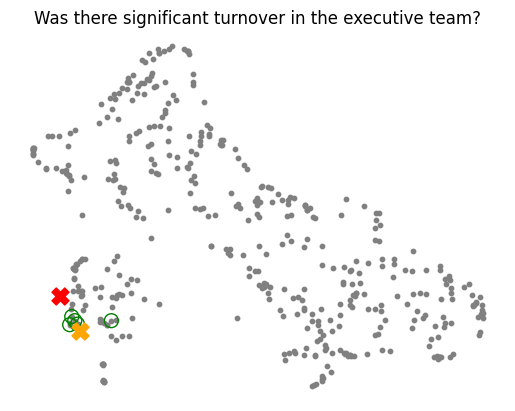

In [19]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

#### Technique 2 - Query expansion with multiple queries
Given an input query, this method instructs an LLM to generate N questions related to the original query and then sends them all (+ the original query) to the retrieval system.

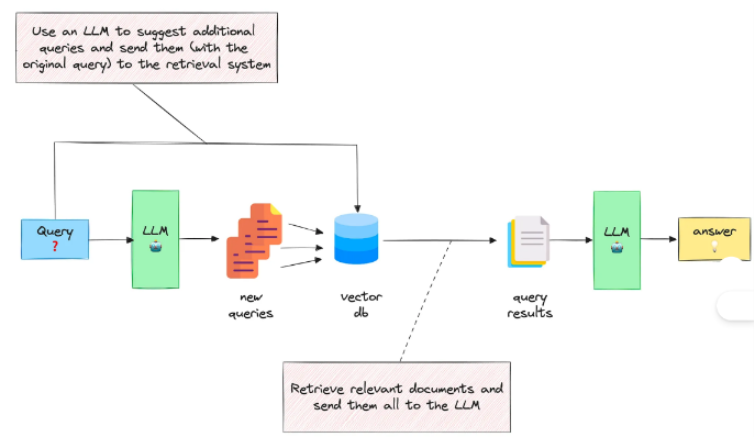

Make multiple queries for the original query using an LLM

In [20]:
def augment_multiple_query(query):
    chain = (
        PromptTemplate.from_template(
            """You are a helpful expert financial research assistant. Your users are asking questions about an annual report.
            Suggest up to five additional related questions to help them find the information they need, for the provided question.
            Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.
            Make sure they are complete questions, and that they are related to the original question.
            Output one question per line
            Quesion: {question}""")
        | llm_gpt4_turbo
        | StrOutputParser()
    )
    return chain.invoke({'question':query})

In [21]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)
augmented_queries = augmented_queries.split('\n')

for query in augmented_queries:
    print(query)

What new products or services were launched last year?
How did market expansion impact revenue growth?
Were there any significant changes in pricing strategy?
What was the impact of currency fluctuations on revenue?
How did customer acquisition trends affect revenue?


In [22]:
# Combine original and augmented queries
queries = [original_query] + augmented_queries
queries

['What were the most important factors that contributed to increases in revenue?',
 'What new products or services were launched last year?',
 'How did market expansion impact revenue growth?',
 'Were there any significant changes in pricing strategy?',
 'What was the impact of currency fluctuations on revenue?',
 'How did customer acquisition trends affect revenue?']

In [23]:
# Get the 5 docs which are pretty close to each query in the queries list
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])


In [24]:
len(results['documents'][0])

5

In [25]:
retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 4 4, respectively. prior
year net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 million and $ 0. 08, r espectively. gross margin and operating
income both included an unfavorable foreign currency impact of 2 %.
segment results of operations ( in millions, except percentages ) 2022
2021 percentage change revenue productivity and business processes $
63, 364 $ 53, 915 18 % intelligent cloud 75, 251 60, 080 25 % more
pers

In [26]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


In [27]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


(-3.8437902450561525,
 7.468723487854004,
 1.8404122352600099,
 10.359510326385498)

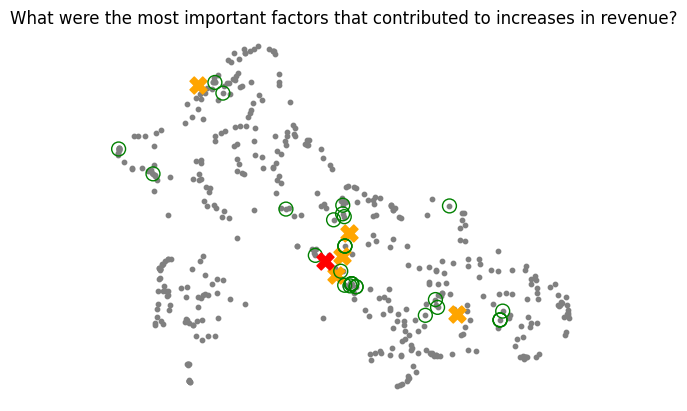

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Query Expansion with cross encoder Re ranking

Cross encoding is a combination of multiple queries and cross encoder re ranking, as user able to generate more questions using LLM, each generated query will able to extract couple of documents from vector database.

Those extracted documents must be passed through a cross-encoder to obtain similarity scores with the initial query. Now we can re ranking does relevant document and pick top 5 to be used as context of our LLM summarization.

Why we need to pick the top 5 documents? In this case we try to avoid the irrelevant documents that we retrieved from vector database. This selection ensures that the cross-encoder focuses on the most similar and meaningful documents, thereby generating a more accurate and concise summary.


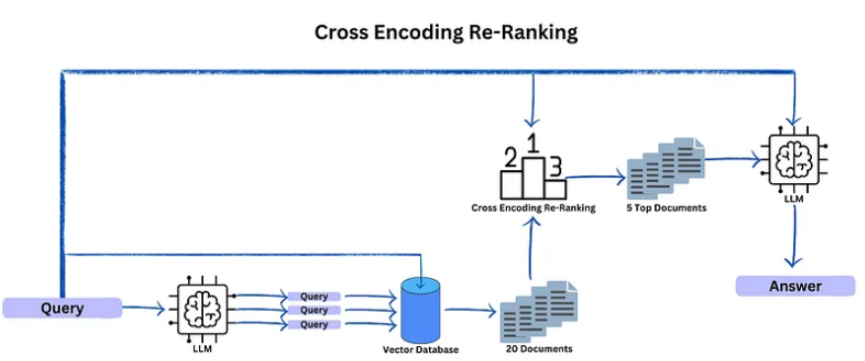

In [29]:
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

#Cross Encoding happens in here
def create_documents(queries, retrieved_documents):

    retrieved_documents = [element for sublist in retrieved_documents for element in sublist]
    unique_a = []
    #If there is duplication documents for each query, make it unique
    for item in retrieved_documents:
        if item not in unique_a:
            unique_a.append(item)

    unique_documents = list(unique_a)

    pairs = []
    for doc in unique_documents:
        pairs.append([queries[0], doc])

    #Cross Encoder Scoring
    scores = cross_encoder.predict(pairs)

    final_queries = []
    for x in range(len(scores)):
        final_queries.append({"score":scores[x],"document":unique_documents[x]})

    #Rerank the documents, return top 5
    sorted_list = sorted(final_queries, key=lambda x: x["score"], reverse=True)
    first_five_elements = sorted_list[:6]
    return first_five_elements

## QnA

In [30]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from IPython.display import Markdown

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """Assistant is a large language model trained by OpenAI. \
        Use the following pieces of retrieved context to answer the question. \
        If you don't know the answer, just say that you don't know. \

        {context}"""),

        ("human", "{question}"),
    ]
)

def format_docs(docs):
    doc_strings = [doc["document"] for doc in docs]
    return "\n\n".join(doc_strings)

top5_docs = create_documents(augmented_queries, retrieved_documents)

chain =  qa_prompt | llm_gpt4_turbo| StrOutputParser()

### Before Query Expansion & Cross Encoder Re-ranking

In [35]:
original_query

'What were the most important factors that contributed to increases in revenue?'

In [38]:
len(retrieved_documents)

6

In [33]:
result = chain.invoke({"question":original_query, "context": '\n\n'.join([doc for doc in retrieved_documents[0]])})
Markdown(result)

Based on the provided context, the most important factors that contributed to increases in revenue include:

1. Growth across each of the company's segments: The company experienced growth in all of its segments, which include Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The percentage increases in revenue for these segments were 18%, 25%, and an unspecified amount for More Personal Computing, respectively.

2. Higher revenue per search and search volume: Excluding traffic acquisition costs, the revenue increased by 27%, which was driven by higher revenue per search and search volume.

3. Growth in Xbox hardware and Xbox content and services: Gaming revenue increased by $860 million or 6%, driven by growth in Xbox hardware and Xbox content and services. Xbox hardware revenue increased by 16% due to continued demand for Xbox Series X|S, and Xbox content and services revenue increased by 3% driven by growth in Xbox Game Pass subscriptions and first-party content.

4. Increase in Surface revenue: Surface revenue increased by $226 million or 3%.

5. Growth in Windows and search and news advertising: Gross margin increased by $3.1 billion or 10%, driven by growth in Windows and search and news advertising.

6. Net tax benefits: The current year net income and diluted EPS were positively impacted by a net tax benefit related to the transfer of intangible properties, which resulted in an increase to net income and diluted EPS of $3.3 billion and $0.44, respectively. The prior year also saw a positive impact from a net tax benefit related to the India Supreme Court decision on withholding taxes, which increased net income and diluted EPS by $620 million and $0.08, respectively.

These factors collectively contributed to the overall increase in the company's revenue.

### After Query Expansion & Re-ranking

In [37]:
top5_docs

[{'score': -1.9916075,
  'document': 'latest offerings as providing significant new functionality or other value, they may reduce their purchases of new software and hardware products or upgrades, unfavorably affecting revenue. we may not achieve significant revenue from new product, service, and distribution channel investments for several years, if at all. new products and services may not be profitable, and even if they are profitable, operating margins for some new products and businesses will not be as high as the m argins we have experienced historically. we may not get engagement in certain features, like edge and bing, that drive post - sale monetization opportunities. our data handling practices across our products and services will continue to be under scrutiny and perceptions of mismanagement, driven by regulatory activity or negative public reaction to our practices or product experiences, could negatively impact product and feature adoption, product design, and product qua

In [32]:
result = chain.invoke({"question":original_query, "context": format_docs(top5_docs)})
display(Markdown(result))
top5_docs

Based on the provided context, the most important factors that contributed to increases in revenue for the fiscal year being discussed were:

1. Microsoft Cloud (formerly Commercial Cloud) revenue growth: The revenue increased by 32% to $91.2 billion, indicating strong performance in cloud services.

2. Office commercial products and cloud services: Revenue increased by 13%, driven by Office 365 commercial growth of 18%.

3. Office consumer products and cloud services: Revenue increased by 11%, with Microsoft 365 consumer subscribers growing to 59.7 million.

4. LinkedIn revenue increase: LinkedIn saw a revenue increase of 34%, which is significant for the professional networking platform.

5. Dynamics products and cloud services: Revenue increased by 25%, with Dynamics 365 growth of 39%, showing strong demand for business applications.

6. Server products and cloud services: Revenue increased by 28%, driven by Azure and other cloud services growth of 45%.

7. Windows OEM revenue: Windows Original Equipment Manufacturer licensing revenue increased by 11%.

8. Windows commercial products and cloud services: Revenue increased by 11%.

9. Xbox content and services: Revenue increased by 3%, with Xbox Game Pass subscriptions and first-party content contributing to the growth.

10. Search and news advertising: Revenue excluding traffic acquisition costs increased by 27%, driven by higher revenue per search and search volume.

11. Gaming revenue: Increased by $860 million or 6%, driven by growth in Xbox hardware and Xbox content and services.

12. Surface revenue: Increased by $226 million or 3%.

These factors highlight the company's diverse portfolio of products and services, with significant growth in cloud-based services, subscription models, and advertising revenue. The growth in these areas helped to drive overall revenue increases and indicates a strong market demand for the company's offerings.

[{'score': -1.9916075,
  'document': 'latest offerings as providing significant new functionality or other value, they may reduce their purchases of new software and hardware products or upgrades, unfavorably affecting revenue. we may not achieve significant revenue from new product, service, and distribution channel investments for several years, if at all. new products and services may not be profitable, and even if they are profitable, operating margins for some new products and businesses will not be as high as the m argins we have experienced historically. we may not get engagement in certain features, like edge and bing, that drive post - sale monetization opportunities. our data handling practices across our products and services will continue to be under scrutiny and perceptions of mismanagement, driven by regulatory activity or negative public reaction to our practices or product experiences, could negatively impact product and feature adoption, product design, and product qua